# Analyzing the Student's t-distribution

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, t
from numpy.random import seed

In [21]:
def gamma_dist(x, a, b):
    a = np.array(a).reshape(1, -1, 1)
    b = np.array(b).reshape(1, 1, -1)
    x = x.reshape(-1, 1, 1)
    return b ** a * x ** (a - 1) * np.exp(-b * x) / gamma(a)

## Simulating a student's t-distribution

In [22]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [23]:
import os
import requests
import pandas as pd
apikey = os.environ["AVANTAGE_API"]


# https://www.alphavantage.co/documentation/
url = "https://www.alphavantage.co/query"
symbol = "TSLA"
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": symbol,
    "outputsize": "full",
    "apikey": apikey
}

r = requests.get(url, params=params)
r

<Response [200]>

In [24]:
stock = pd.DataFrame.from_dict(r.json()["Time Series (Daily)"], orient="index", dtype=float)
stock.index = pd.to_datetime(stock.index)
stock = stock.sort_index()

stock_ret = stock.rename({"5. adjusted close": symbol}, axis=1)[symbol].pct_change().dropna()
N = len(stock_ret)

In [25]:
stock_ret.index.min()

Timestamp('2010-06-30 00:00:00')

In [26]:
stock_ret.index.max()

Timestamp('2020-09-17 00:00:00')

## TSLA returns as a normal distribution

Text(0.5, 1.0, 'Normal distribution adjusted to TSLA')

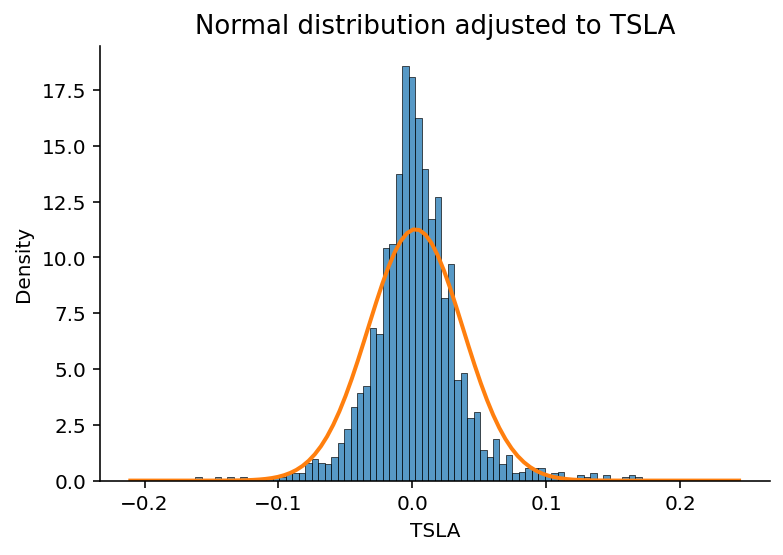

In [27]:
xrange = np.linspace(stock_ret.min(), stock_ret.max(), 100)

tsla_mu = stock_ret.mean()
tsla_std = stock_ret.std(ddof=1)

N_tsla = norm(loc=tsla_mu, scale=tsla_std)
sns.histplot(stock_ret, stat="density")
plt.plot(xrange, N_tsla.pdf(xrange), c="tab:orange", linewidth=2)
plt.title("Normal distribution adjusted to TSLA", fontsize=13)

## TSLA returns as a t-distribution

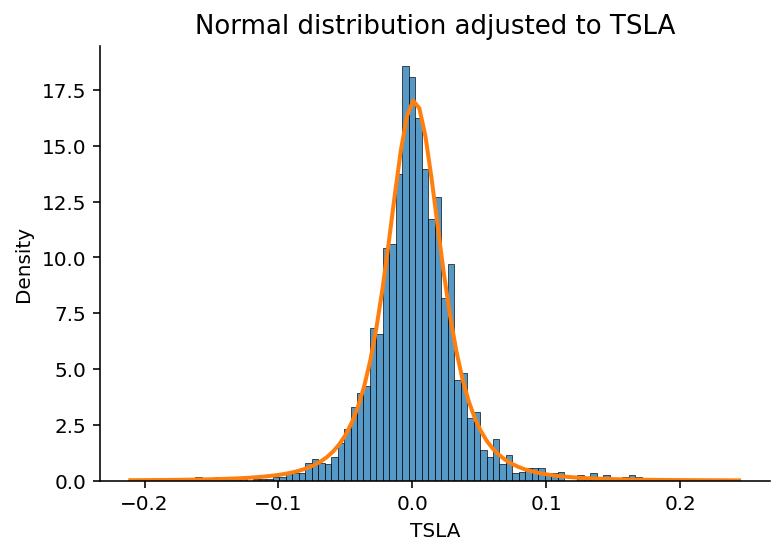

In [30]:
df, loc, scale = t.fit(stock_ret)

t_tsla = t(df, loc, scale)
sns.histplot(stock_ret, stat="density")
plt.plot(xrange, t_tsla.pdf(xrange), c="tab:orange", linewidth=2)
plt.title("Normal distribution adjusted to TSLA", fontsize=13);

## Simulating a t-process

In [10]:
alpha = df / 2
beta = df / (2 * scale)
mu = loc

In [11]:
beta / alpha + np.array([0, 1]) *  np.sqrt(beta ** 2 / alpha)

array([ 46.5251921 , 102.29762485])

In [12]:
gam = gamma(a=alpha, scale=beta)

seed(272812)
n_samples = 120
samples = np.empty(n_samples)
sigma_samples = np.empty(n_samples)
for ix in range(n_samples):
    tau = gam.rvs()
    sigma = np.sqrt(1 / tau)
    N = norm(loc=mu, scale=sigma)
    samples[ix] = N.rvs() / 100
    sigma_samples[ix] = sigma

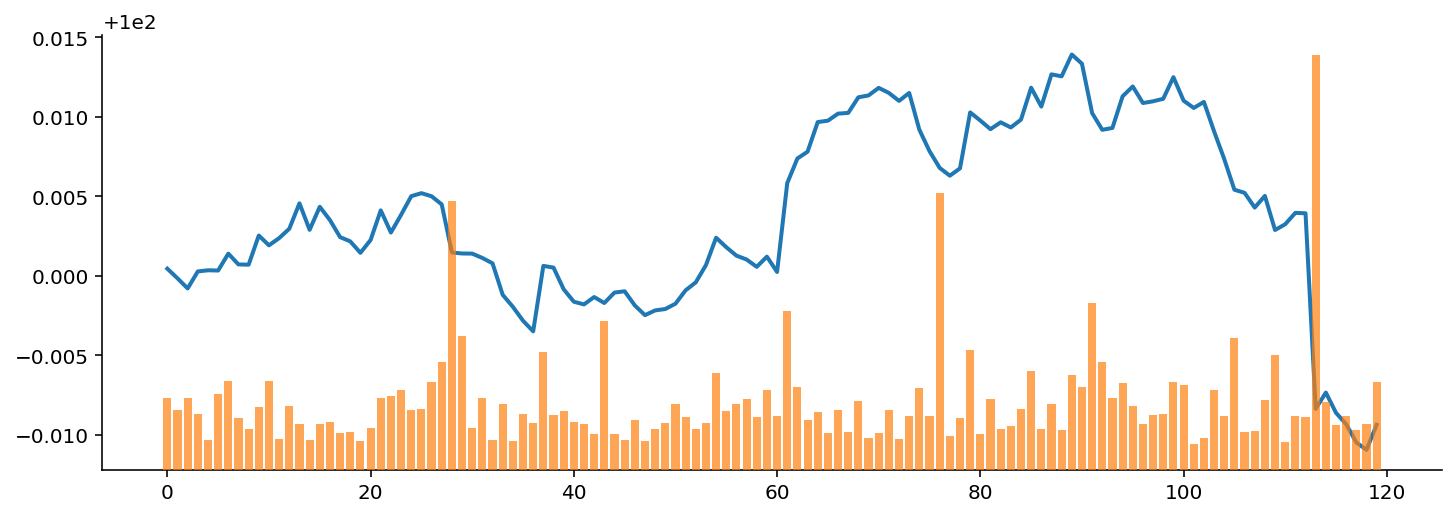

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
ax2 = ax.twinx()
ax.plot(100 * (1 + samples / 120).cumprod(), linewidth=2)
ax2.bar(np.ones_like(sigma_samples).cumsum() - 1,
        sigma_samples, color="tab:orange", alpha=0.7)
# ax2.axvline(102, color="tab:red", linewidth=20, alpha=0.3)
# ax2.axvline(102, color="tab:red", linewidth=1, linestyle="--")
ax2.axis("off");

/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


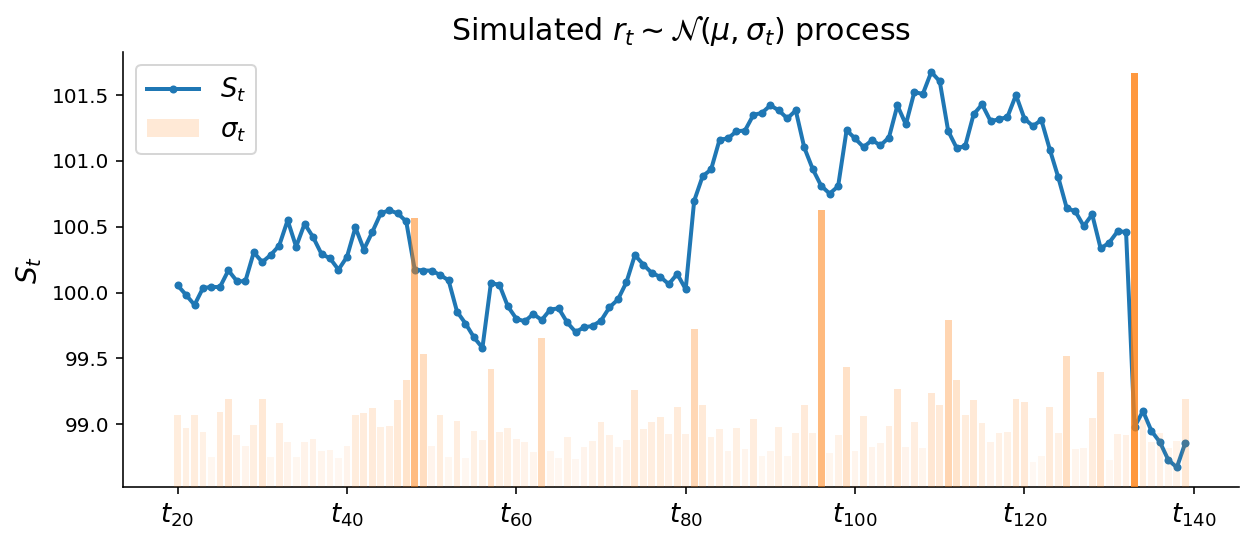

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()

St = 100 * (1 + samples).cumprod()
alpha_values = 0.8 * sigma_samples / (sigma_samples.max())

l1 = ax.plot(St, linewidth=2, marker="o", markersize=3)
for i, (sigma, alpha_i) in enumerate(zip(sigma_samples, alpha_values)):
    l2 = ax2.bar(i, sigma_samples[i], color="tab:orange", alpha=alpha_i)
ax2.axis("off");
plt.legend([l1[0], l2], [r"$S_t$", r"$\sigma_t$"], fontsize=13)
ax.set_ylabel(r"$S_t$", fontsize=14)
plt.title(r"Simulated $r_t \sim \mathcal{N}(\mu, \sigma_t)$ process", fontsize=15);
ticks = ax.get_xticks()[1:]
ax.set_xticklabels(["$t_{time}$".replace("time", str(int(t))) for t in ticks], fontsize=13);


In [15]:
samples.argmin()

113

In [16]:
sigma_samples[samples.argmin()]

0.8958140081096895

In [17]:
samples[samples.argmin()] * 100

-1.4748159113562087

### Fitting a normal distribution